In [1]:
import pandas as pd
import re
import numpy as np
import json

In [2]:
df = pd.read_csv('submissions/wbf_0.88x no aug best conf 0.5 no reid lb 0.306_0.882 manyaug best conf 0.7 no reid lb 0.30378 lb 0.307922 REID lb 0.6693.csv')
len(df[df['class'] == 1])

1043

In [3]:
reid_df = pd.read_csv('./log_SGD_continue_1e-4/results.csv')
with open('../RT-DETR/submissions/wbf_0.88x no aug best conf 0.5 no reid lb 0.306_0.882 manyaug best conf 0.7 no reid lb 0.30378 lb 0.307922_bbox_mapping.json', 'r') as f:
    mapping = json.load(f)
batched_mapping = {}
for k, v in mapping.items():
    k = k.replace('\\', '/')
    batched_mapping['/'.join(k.split('/')[:4] + ['test_old'] + k.split('/')[5:])] = v  # 6: for image folder structure mapping json, 5: for new one
mapping = batched_mapping

In [56]:
# run this cell if results.csv is from a rotation expanded inference
pattern = re.compile(r'([-\d]+)_c(\d+)')
result_counter = {}
threshold = 2  # between 1 to 4, how many rotated image confirms to be counted for true confirm
def combine(row):
    fp = row['file_path'].replace('\\', '/').split('.png')[0][:-2] + '.png'  # remove the last 2 char which is the rotation index _0, _1 etc
    fp_without_slash_replacement = row['file_path'].split('.png')[0][:-2] + '.png'  # remove the last 2 char which is the rotation index _0, _1 etc
    if fp not in result_counter:  # only do the below if first time seeing this fp, else just write the same row then later will remove duplicat rows
        result_counter[fp] = 0
        for i in range(4):
            fp_rot = fp_without_slash_replacement.split('.png')[0] + f'_{i}.png'
            if np.all(reid_df[reid_df['file_path'] == fp_rot]['result'] == 1):
                result_counter[fp] += 1
    row['class'] = 1 if result_counter[fp] >= threshold else 0  # threshold is 2
    row['Image_ID'] = 'image_' + pattern.search(fp).groups()[-1].zfill(4)
    row['confidence'] = mapping[fp]['confidence']
    row['ymin'] = mapping[fp]['ymin']
    row['xmin'] = mapping[fp]['xmin']
    row['ymax'] = mapping[fp]['ymax']
    row['xmax'] = mapping[fp]['xmax']
    return row

cols = ['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']

reid_df_new = reid_df.apply(combine, axis=1)[cols]
reid_df_new.drop_duplicates(inplace=True)
reid_df_new.to_csv('submissions/wbf_0.88x no aug best conf 0.5 no reid lb 0.306_0.882 manyaug best conf 0.7 no reid lb 0.30378 lb 0.307922 RR thresh 0.8669 ROT.csv',index=False)

(array([2318.,    0.,    0., 1130.]),
 array([0., 1., 2., 3., 4.]),
 <BarContainer object of 4 artists>)

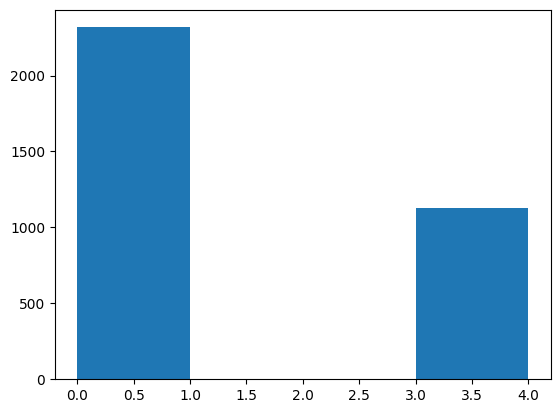

In [57]:
# plot results counter
import matplotlib.pyplot as plt
plt.hist(result_counter.values(), range=[0, 4], bins=4)

In [25]:
# taking min dist with very loose threshold
threshold = 0.85
pattern = re.compile(r'([-\d]+)_c(\d+)')
image_bboxes = {}
def count(row):
    fp = row['file_path'].replace('\\', '/')
    image_id = 'image_' + pattern.search(fp).groups()[-1].zfill(4)
    if image_id not in image_bboxes:
        image_bboxes[image_id] = []
    image_bboxes[image_id].append({'dist': row['result'],
                                   'confidence': mapping[fp]['confidence'],
                                   'ymin': mapping[fp]['ymin'],
                                   'xmin': mapping[fp]['xmin'],
                                   'ymax': mapping[fp]['ymax'],
                                   'xmax': mapping[fp]['xmax']})
for row in reid_df.iterrows():
    count(row[1])
combined = []
for image_id in image_bboxes:
    candidates = [box for box in image_bboxes[image_id] if box['dist'] <= threshold]
    if not candidates:
        candidates = [{'dist': 1e99}]  # if no candidates, just fake 1 but it will fail the check later so its still gonna be 0
    candidates.sort(key=lambda x: x['dist'], reverse=False)
    for box in image_bboxes[image_id]:
        row = {
            'Image_ID': image_id,
            'class': 1 if box == candidates[0] else 0,
            'confidence': box['confidence'],
            'ymin': box['ymin'],
            'xmin': box['xmin'],
            'ymax': box['ymax'],
            'xmax': box['xmax']}
        combined.append(row)

cols = ['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']

reid_df_new = pd.DataFrame.from_dict(combined)[cols]
reid_df_new.to_csv(f'submissions/wbf_0.88x no aug best conf 0.5 no reid lb 0.306_0.882 manyaug best conf 0.7 no reid lb 0.30378 lb 0.307922 RR thresh with min {threshold}.csv',index=False)

In [ ]:
pattern = re.compile(r'([-\d]+)_c(\d+)')
def combine(row):
    fp = row['file_path'].replace('\\', '/')
    row['Image_ID'] = 'image_' + pattern.search(fp).groups()[-1].zfill(4)
    row['class'] = row['result']
    row['confidence'] = mapping[fp]['confidence']
    row['ymin'] = mapping[fp]['ymin']
    row['xmin'] = mapping[fp]['xmin']
    row['ymax'] = mapping[fp]['ymax']
    row['xmax'] = mapping[fp]['xmax']
    return row

cols = ['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']

reid_df_new = reid_df.apply(combine, axis=1)[cols]
reid_df_new.to_csv('submissions/wbf_0.88x no aug best conf 0.5 no reid lb 0.306_0.882 manyaug best conf 0.7 no reid lb 0.30378 lb 0.307922 no RR thresh 0.0013236288040655365.csv',index=False)